## Sistema de recomendación: caso Netflix

Objetivo: construir un sistema de recomendación de películas basado en los datos de Netflix.

Los pasos a seguir son:
* Análisis de datos
* Pre-procesamiento
* Construcción del sistema de recomendación
    - Usando filtrado colaborativo
    - Usando las correlaciones de Pearson

[Créditos y fuente de datos](https://www.kaggle.com/laowingkin/netflix-movie-recommendation)

In [1]:
"""Carga de bibliotecas"""
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

In [2]:
"""Carga de la base de datos"""
#selección de ID y rating
df = pd.read_csv('../data/netflix/combined_data_1.txt', header = None, names = ['User_Id', 'Rating'], usecols = [0,1])

df['Rating'] = df['Rating'].astype(float)
print('Tamaño de la base de datos: {}'.format(df.shape))
print('-Ejemplos-')
print(df.iloc[::5000000, :])

Tamaño de la base de datos: (24058263, 2)
-Ejemplos-
          User_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


## Análisis de datos

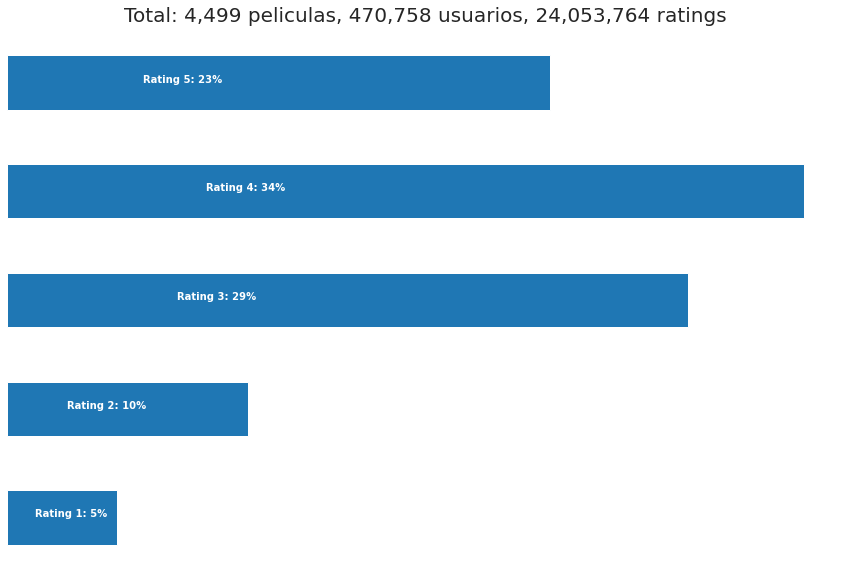

In [3]:
"""Visualizamos los datos de Netflix"""
p = df.groupby('Rating')['Rating'].agg(['count'])

movie_count = df.isnull().sum()[1]#Se obtiene el total de películas
cust_count = df['User_Id'].nunique() - movie_count#Se obtiene el total de usuarios
rating_count = df['User_Id'].count() - movie_count#Se obtiene el total de ratings

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total: {:,} peliculas, {:,} usuarios, {:,} ratings'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

Se observa que la mayoría de los ratings tiende a ser positiva (>3)

## Pre-procesamiento

In [4]:
"""Crear una matriz de numpy para el ID de la película (procesamiento más eficiente)"""
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # matriz de numpy
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Se toma en cuenta el último registro y la longitud correspondiente
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Películas (numpy): {}'.format(movie_np))
print('Tamaño: {}'.format(len(movie_np)))

Películas (numpy): [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Tamaño: 24053764


In [5]:
"""Visualizamos nuevamente"""
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['User_Id'] = df['User_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])

-Dataset examples-
          User_Id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825


## División de los datos

Algunos criterios que se toman en cuenta:

- Eliminar películas con menos ratings (relativamente no son populares)
- Eliminar a los usuarios que dieron menos reseñas (son relativamente menos activos)

In [6]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Películas menos populares: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('User_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Usuarios menos activos: {}'.format(cust_benchmark))

Películas menos populares: 1799.0
Usuarios menos activos: 52.0


In [7]:
"""Después de reducir la base de datos, vemos cómo queda"""
print('Tamaño original: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['User_Id'].isin(drop_cust_list)]
print('Tamaño después de la reducción: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Tamaño original: (24053764, 3)
Tamaño después de la reducción: (17337458, 3)
-Data Examples-
          User_Id  Rating  Movie_Id
696        712664     5.0         3
6932490   1299309     5.0      1384
13860273   400155     3.0      2660
20766530   466962     4.0      3923


In [8]:
"""Generar una tabla pivote"""
df_p = pd.pivot_table(df,values='Rating',index='User_Id',columns='Movie_Id')

print(df_p.shape)

(143458, 1350)


## Mapeo de datos

In [9]:
"""Carga de la base de datos de películas"""
df_title = pd.read_csv('../data/netflix/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


## Construcción del sistema de recomendación usando filtrado colaborativo

Usamos la biblioteca [Surprise](http://surpriselib.com/) y se emplea el algoritmo de [factorización de matrices probabilísticas](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD).

In [10]:
reader = Reader()
#Con fines prácticos y para mejorar el rendimiento, únicamente se utilizando los primeros 100 mil registros
data = Dataset.load_from_df(df[['User_Id', 'Movie_Id', 'Rating']][:], reader)
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'test_rmse': array([0.84787407, 0.84800261, 0.84791944, 0.84848291, 0.84825324]),
 'test_mae': array([0.65825397, 0.65844116, 0.6584262 , 0.65861519, 0.65827341]),
 'fit_time': (601.1181998252869,
  607.0085506439209,
  615.9723484516144,
  586.3250668048859,
  585.3966884613037),
 'test_time': (44.58849883079529,
  46.67794370651245,
  45.162806034088135,
  34.89421224594116,
  34.51215195655823)}

In [11]:
"""Analicemos al usuario con ID:785314 """
df_785314 = df[(df['User_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314) #Estas son las películas que ha visto

Movie_Id
57                                            Richard III
175                                        Reservoir Dogs
311                                               Ed Wood
329                                                 Dogma
331                                           Chasing Amy
395                                         Captain Blood
788                                                Clerks
798                                                  Jaws
907                                       Animal Crackers
985                                             The Mummy
1552                                          Black Adder
1905    Pirates of the Caribbean: The Curse of the Bla...
2000                          Four Weddings and a Funeral
2122                                 Being John Malkovich
2342                                        Super Size Me
2360                                  Singin' in the Rain
2430                           Alien: Collector's Edition
2443 

In [12]:
"""Predecir las películas que le gustaría al usuario: 785314"""

user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

data = Dataset.load_from_df(df[['User_Id', 'Movie_Id', 'Rating']], reader) #Traemos la base de datos completa

trainset = data.build_full_trainset()
svd.fit(trainset)

user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)
user_785314 = user_785314.drop('Movie_Id', axis = 1)
user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))

        Year                                          Name  Estimate_Score
3768  2004.0              Wonderfalls: The Complete Series        5.000000
2101  1994.0                        The Simpsons: Season 6        5.000000
3045  1990.0             The Simpsons: Treehouse of Horror        4.993798
2171  1991.0                        The Simpsons: Season 3        4.937169
1019  1989.0                        The Simpsons: Season 1        4.872105
1551  1983.0                                   Black Adder        4.825152
4114  1999.0                       The Simpsons: Bart Wars        4.805160
1434  2001.0  Wallace & Gromit in Three Amazing Adventures        4.769497
2056  2001.0            Buffy the Vampire Slayer: Season 6        4.722436
2018  2004.0                              Samurai Champloo        4.712778


## Generando recomendaciones usando la correlación de Pearson

Se usará la correlación de Pearson para medir la correlación lineal entre los ratings de todos los pares de películas.

In [13]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

In [14]:
recommend("Finding Nemo (Widescreen)", 0)

For movie (Finding Nemo (Widescreen))
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                          Name   count      mean
 1.000000                     Finding Nemo (Widescreen)  140979  4.415523
 0.325961                                       Shrek 2  153996  4.144543
 0.320806                The Lion King: Special Edition   67575  4.195191
 0.312034  The Land Before Time VII: Stone of Cold Fire    2083  3.711954
 0.300824                        Pooh's Heffalump Movie    9312  3.862865
 0.293018                     Aladdin: Platinum Edition   51856  4.182621
 0.288898         VeggieTales: The Ballad of Little Joe    3725  3.842953
 0.287817                   The Hunchback of Notre Dame    1883  3.482209
 0.284445  Brother Bear (Theatrical Widescreen Version)   33708  3.746707
 0.281412                               Lilo and Stitch   39752  3.823254


In [15]:
recommend("X2: X-Men United", 0)

For movie (X2: X-Men United)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                                   Name  count      mean
 1.000000                                       X2: X-Men United  98720  3.932202
 0.384550                               Batman Beyond: The Movie   2614  3.726855
 0.375967                                         Justice League   3591  3.710944
 0.361393                       Justice League: Justice on Trial   2961  3.718001
 0.338025                     Batman Beyond: Return of the Joker   3704  3.604752
 0.335256                                          Batman Begins  54922  4.236699
 0.328229                           Batman: Mask of the Phantasm   2823  3.767977
 0.327040  Batman: The Animated Series: Tales of the Dark Knight   2432  3.583059
 0.316666                        Dragon Ball Z: Super Android 13   2426  3.428689
 0.316166                               Mortal Kombat: The Movie   7633  3.165466
